# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

> NOTE: If you're running this locally - please skip this step.

In [1]:
#!pip install -qU langchain langchain_openai langchain-community langgraph arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.4/412.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [20]:
uuid4().hex[0:8]

'108f88af'

In [3]:
#from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE6 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [6]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:


The model uses natural language understanding to interpret the user’s intent, then matches that intent to a predefined set of tools or APIs. The selection logic can be built into the system prompt or handled by a routing mechanism (like conditional nodes or tool routers). It essentially treats tool selection like a reasoning task—choosing the tool that best helps generate an accurate, grounded response.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [8]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [9]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [10]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [11]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [12]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [13]:
compiled_graph = uncompiled_graph.compile()

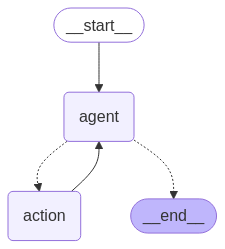

In [36]:
from IPython.display import Image

Image(compiled_graph.get_graph().draw_mermaid_png())

#### ❓ Question #2:

Yes — and it's recommended.

Most frameworks do include or allow setting a max iteration limit to avoid infinite loops or overly long processing. This is often called something like: max_iterations, max_steps, max_loops. Without a limit, an agent might keep calling tools or taking actions indefinitely if it doesn't reach a "done" state.

If not, how could we impose a limit to the number of cycles? Noted above (max_iterations, max_steps, max_loops)

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [38]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    print(chunk)
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values.keys())
        print(values["messages"])
        print("\n\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V07cAjDsjPwZ60umvPIBXuEF', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 162, 'total_tokens': 189, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a6889ffe71', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ef93a57-da38-4447-9408-7aa3f4d12012-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets 2023'}, 'id': 'call_V07cAjDsjPwZ60umvPIBXuEF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 27, '

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [21]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SjPUhiObU6xuidF3wcKDuUkD', 'function': {'arguments': '{"query":"QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 178, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_17316073ab', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9b7a0f5f-77e6-49ed-bc49-a3078469c2b5-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_SjPUhiObU6xuidF3wcKDuUkD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 178, 'output_tokens': 17, 'total_tokens': 195, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [16]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [19]:
agent_chain.invoke({"question" : "What is RAG?"})

"RAG stands for Retrieval-Augmented Generation. It is a technique used in natural language processing (NLP) that combines retrieval-based methods with generative models to improve the quality and relevance of generated text. Here's how it generally works:\n\n1. **Retrieval**: The system first retrieves relevant documents or pieces of information from a large corpus or database. This step is crucial for grounding the generative model in factual and contextually relevant information.\n\n2. **Augmentation**: The retrieved information is then used to augment the input to a generative model. This can involve concatenating the retrieved text with the original input or using it to inform the model's understanding of the context.\n\n3. **Generation**: Finally, a generative model, such as a transformer-based language model, uses the augmented input to produce a response or generate text. The inclusion of retrieved information helps ensure that the output is more accurate and contextually approp

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [23]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]

In [24]:
[{"question" : q} for q in questions]

[{'question': 'What optimizer is used in QLoRA?'},
 {'question': 'What data type was created in the QLoRA paper?'},
 {'question': 'What is a Retrieval Augmented Generation system?'},
 {'question': 'Who authored the QLoRA paper?'},
 {'question': 'What is the most popular deep learning framework?'},
 {'question': 'What significant improvements does the LoRA system make?'}]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [25]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

{'example_ids': ['f6dd1cae-d925-4116-9f26-f65f19022ee3',
  '6c35d8d3-64eb-4feb-b9b7-16e5a4dc6a80',
  '18141ee1-f3d6-410b-9445-ccb0525bbbae',
  '704b3ede-460a-4a9b-8096-6a347cf63b01',
  '4fa8d0ec-30ed-4d4a-bbc1-eb23303e201d',
  '6b3f2a61-66ad-4b93-95eb-1ddc5a52cbd5'],
 'count': 6}

#### ❓ Question #3:

How are the correct answers associated with the questions?

when the answer has the exact match of these terms. If not, that would be evaluated as incorrect.

> NOTE: Feel free to indicate if this is problematic or not

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [26]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

Possibly, we can define what's "good enough" based on the task. For example, in QA, factually correct even if phrased differently. Using an LLM to rate the predicted vs. reference answers on scales like correctness, relevance, helpfulness, or completeness. This gives a softer, more human-like evaluation.



> NOTE: Alternatively you can suggest where gaps exist in this method.

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [27]:
experiment_results = client.evaluate(
    agent_chain,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"RAG Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'RAG Pipeline - Evaluation - da40-17af742f' at:
https://smith.langchain.com/o/9d6a760c-505a-4b81-8b76-580952ac0db8/datasets/481cbc6e-49fc-4775-8caf-a81e048e2cf4/compare?selectedSessions=ffe27064-5057-4ca0-bc7e-b63b4756c97e




0it [00:00, ?it/s]

In [28]:
experiment_results

,inputs.question,outputs.output,error,reference.must_mention,feedback.must_mention,execution_time,example_id,id
0,What is a Retrieval Augmented Generation system?,A Retrieval Augmented Generation (RAG) system ...,None,"[ground, context]",False,8.808756,18141ee1-f3d6-410b-9445-ccb0525bbbae,e64a900c-5213-4286-b868-df73eec9383b
1,What is the most popular deep learning framework?,The most popular deep learning frameworks in 2...,None,"[PyTorch, TensorFlow]",True,6.945928,4fa8d0ec-30ed-4d4a-bbc1-eb23303e201d,7d1156e3-99fb-4139-925a-d3ea36eddca8
2,What significant improvements does the LoRA sy...,The LoRA (Low-Rank Adaptation) system has made...,None,"[reduce, parameters]",False,21.684463,6b3f2a61-66ad-4b93-95eb-1ddc5a52cbd5,bb322ef5-5953-4a70-bbf6-4cb79d5d5ff9
3,What data type was created in the QLoRA paper?,The QLoRA paper introduced a novel data type c...,None,"[NF4, NormalFloat]",True,22.807172,6c35d8d3-64eb-4feb-b9b7-16e5a4dc6a80,e599a01c-1e5b-4337-b2c8-0d70c4e2a1a9
4,Who authored the QLoRA paper?,"The QLoRA paper titled ""Accurate LoRA-Finetuni...",None,"[Tim, Dettmers]",False,33.104154,704b3ede-460a-4a9b-8096-6a347cf63b01,7abd93e4-e9d0-4060-86cb-70d2f95badd5
5,What optimizer is used in QLoRA?,"QLoRA uses ""paged optimizers"" to manage memory...",None,"[paged, optimizer]",True,16.917086,f6dd1cae-d925-4116-9f26-f65f19022ee3,c93a6856-55c1-4efa-aafc-599cd9e02bfe


## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [29]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE

In [30]:
# create an instance of the define AgentState class that has messages as a key in its state to be modified
graph_with_helpfulness_check = StateGraph(AgentState)

# create an instance of the call_model function and pass it to the graph as an agent node
graph_with_helpfulness_check.add_node("agent", call_model)

# create an instance of the tool_node function and pass it to the graph as an action node
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE

In [31]:

# set the entry point of the graph to the agent node
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE

In [32]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# define a function that takes a state as an argument.It is a conditional edge that checks if the last message has tool calls. If it does,
# it returns the action node. Otherwise, it returns the agent node.
def tool_call_or_helpful(state):
  """
  This function is a conditional edge that checks if the last message has tool calls. If it does,
  it returns the action node. Otherwise, it returns the agent node.
  """
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  # get the initial query and final response from the state
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  # check if the length of the state is greater than 10
  if len(state["messages"]) > 10:
    return "END"

  # define a prompt template that takes the initial query and final response
  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  # create an instance of the prompt template
  prompt_template = PromptTemplate.from_template(prompt_template)

  # create an instance of the helpfulness_check_model
  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  # create an instance of the helpfulness_chain that takes the initial query and final response as input
  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  # create an instance of the helpfulness_response that takes the initial query and final response as input
  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  # check if the helpfulness_response is "Y"  
  if "Y" in helpfulness_response:
    # if the helpfulness_response is "Y", return the end node
    return "end"
  else:
    # if the helpfulness_response is not "Y", return the continue node
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!


It get the initial query and final response from the state, it checks if the length of the state is greater than 10 (if Yes, it exits).
It also defines a prompt template that takes the initial query and final response. It also creates an instance of the helpfulness_chain that 
takes the initial query and final response as input. It check if the helpfulness_response is "Y". If Yes, it ends. Otherwise (considering that the
length is not greater thatn the recursion limits) it returns back to agent node to run the query again for potentially more relevant (helpful)
response.  

In [33]:
# checking the edge case in our grapg, via adding conditional_edges to our graph, and calling function we just created.
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    # This call routs the flow to either agent, action, or END.
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

checking the edge case in our graph, via adding conditional_edges to our graph, and calling function we just created.
What this function calling returns, routs the flow to either agent, action, or END.


In [34]:
# From action node we always return back to our agent node (the llm, the brain)
graph_with_helpfulness_check.add_edge("action", "agent")

From action node we always return back to our agent node (the llm, the brain)


In [35]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

Now, we complie our graph to be able to invoke it by our input query.

In [29]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7GzJ36E7AqUM6yfbvuNwMVRA', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_dH7R2o9CDYoEmih5hx3dtxr1', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_1opyXvimXN6yz5z9EFtlUgCG', 'function': {'arguments': '{"query": "Attention mechanism in machine learning"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 177, 'total_tokens': 250, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_17316073ab', 'finish_reason': 'tool_calls', 'logprobs': Non

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [30]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [31]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

**Prompt Engineering Definition:**

Prompt engineering is the process of designing and refining input prompts to effectively guide the behavior of AI models. It involves structuring or crafting instructions to produce the best possible output from a generative AI model. This can include phrasing a query, specifying a style, choice of words and grammar, providing relevant context, or describing a character for the AI to mimic. It is a technique used to refine large language models (LLMs) with specific or recommended prompts to improve their accuracy and effectiveness. [Sources: Coursera, Wikipedia, BYU, TechTarget, Stanford]

**History of Prompt Engineering:**

The history of prompt engineering is closely tied to the development and evolution of natural language processing (NLP) and artificial intelligence (AI) systems. It can be traced back to the early days of AI research when data scientists were testing various ways of interacting with AI models. The need for structured guidance in 